# pix2pix in Tensorflow
The original repo can be found [here](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/docs/datasets.md).
Dataset That will be used: [facades](http://cmp.felk.cvut.cz/~tylecr1/facade/)

## preparation
Please download and unzip the [dataset](http://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip) into the directory `./dataset/` before running!


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Load images

In [2]:
images = []
labels = []

import glob
from PIL import Image

path = "dataset/base/"

for image_path in glob.glob(path + "*.png"):
    img = Image.open(image_path)
    img = img.resize((200, 200))
    images.append(np.array(img.getdata()).reshape((200, 200)))

    lbl = Image.open(image_path.replace(".png", ".jpg"))
    lbl = lbl.resize((200, 200))
    labels.append(np.array(lbl.getdata()).reshape((200, 200, 3)))

#### Visualization of random images and their labels

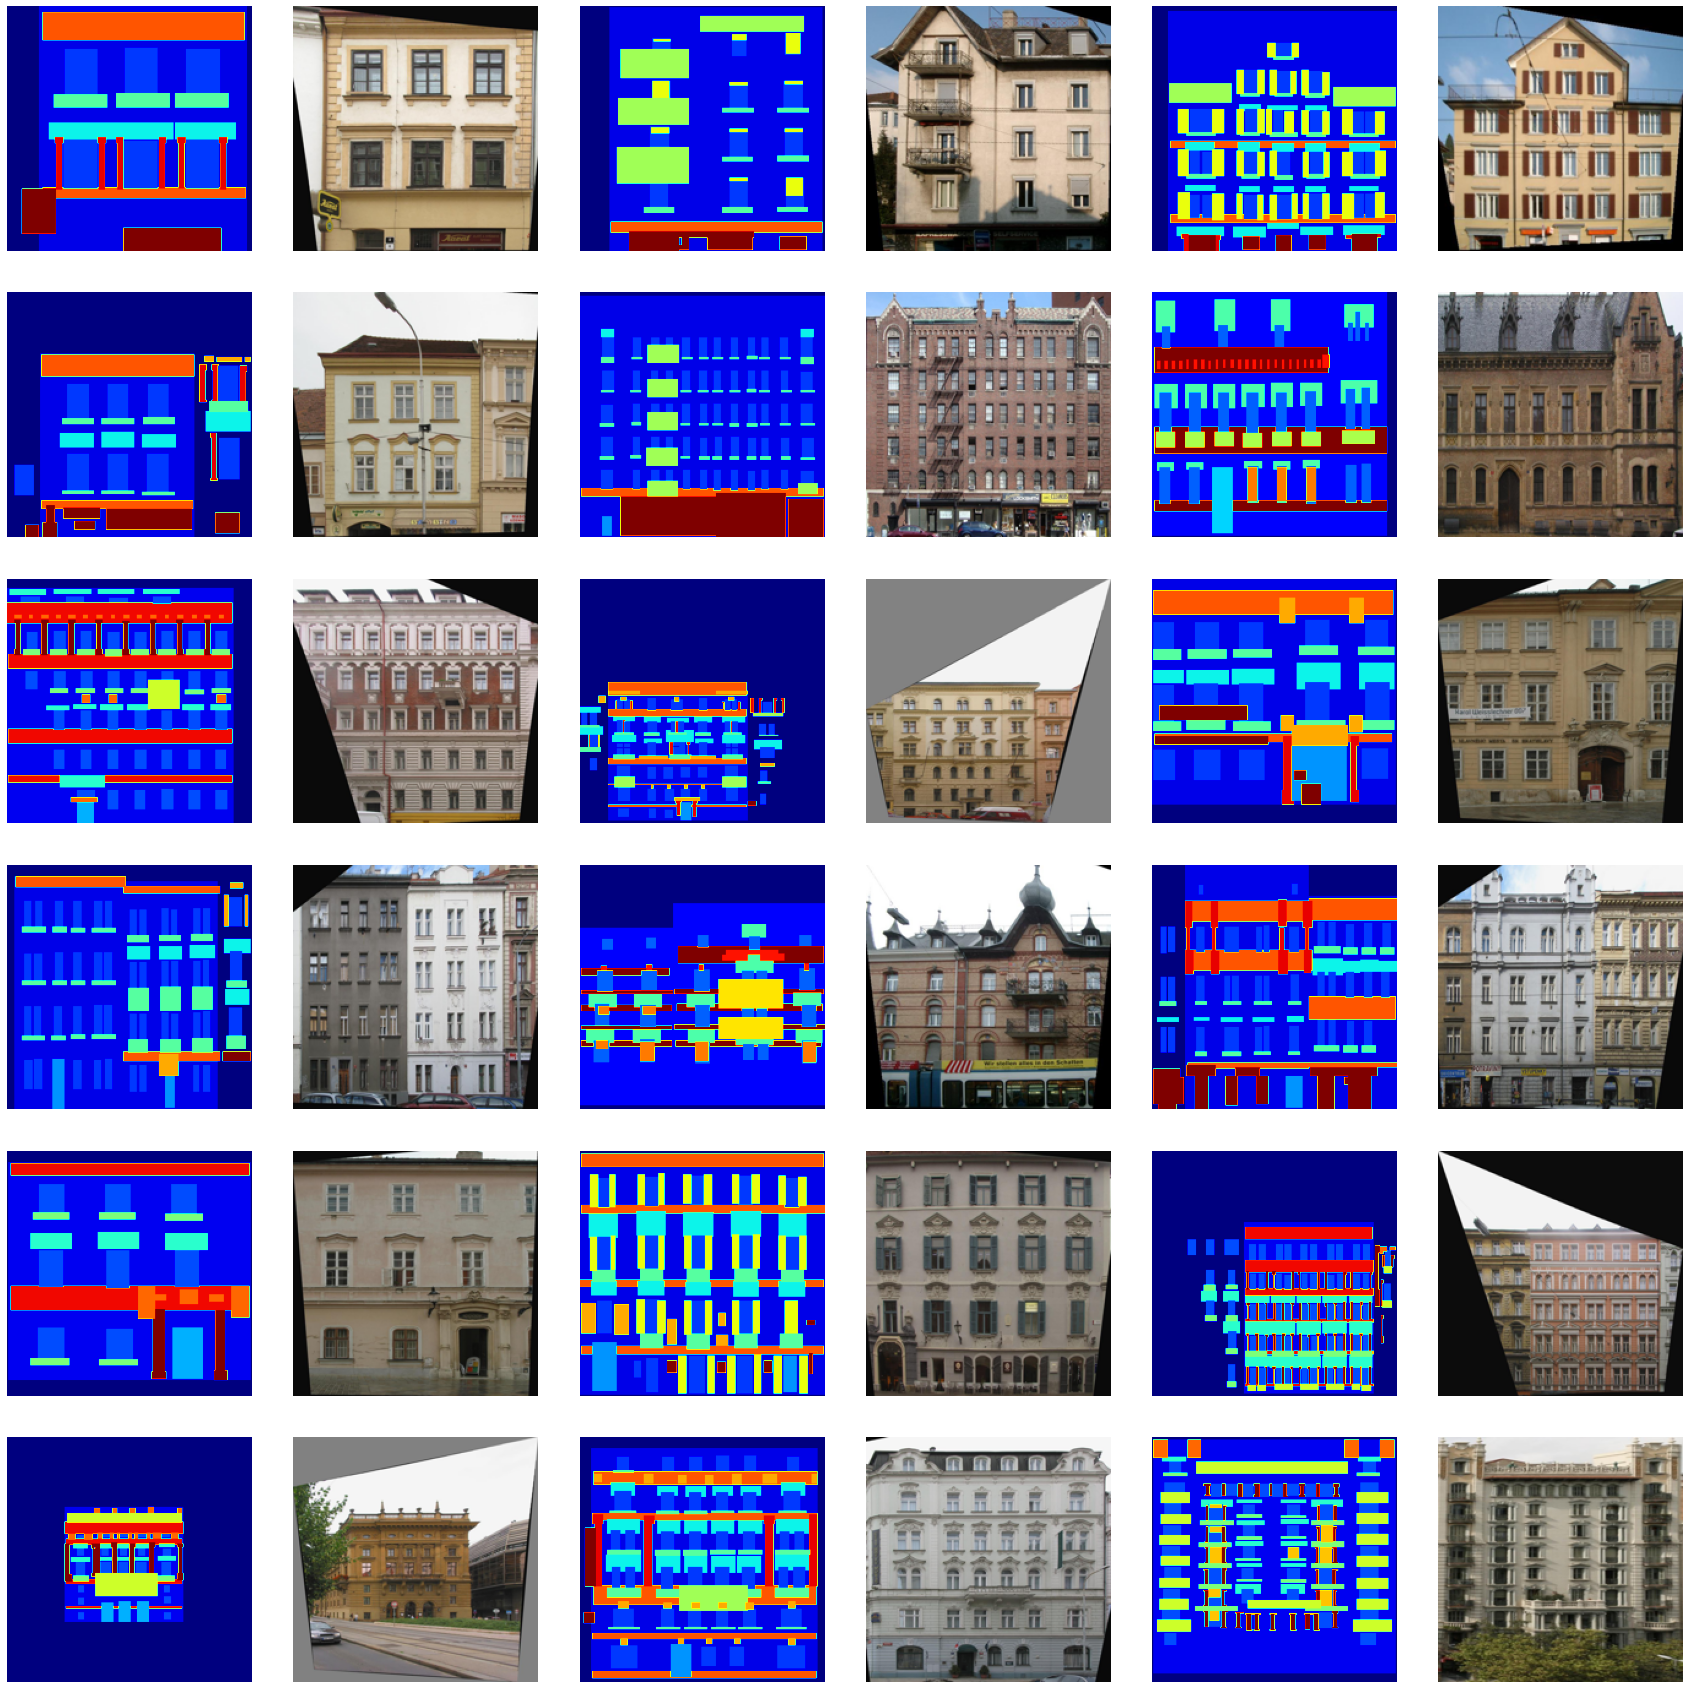

In [6]:
%matplotlib inline
fig, ax = plt.subplots(6,6,figsize=(24,24))
fig.tight_layout()
ax = ax.flatten()
for i in range(18):
    rand = np.random.randint(len(images)-1)
    img = images[rand]
    lbl = labels[rand]
    
    ax[2 * i].imshow(img, cmap='jet')
    ax[2 * i].axis("off")
    ax[2 * i + 1].imshow(lbl)
    ax[2 * i + 1].axis("off")

## Split dataset into train and test

In [4]:
import math
num_test = math.floor(len(images) * 0.1)

test_images = np.array(images[:num_test], dtype=np.float32)
test_labels = np.array(labels[:num_test], dtype=np.float32)

train_images = np.array(images[num_test:], dtype=np.float32)
train_labels = np.array(labels[num_test:], dtype=np.float32)

## Generate tf datasets

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_dataset = train_dataset.shuffle(buffer_size=50000)
batch_size = 64
train_dataset = train_dataset.batch(batch_size=batch_size)
test_dataset = test_dataset.batch(10000)

## Define the models

In [11]:
from tensorflow.keras.layers import Layer

### Define the disceiminator
**16 x 16:**
- c64
- c128 
- conv to 1d
- sigmoid

**70 x 70:**
- c64 
- c128 
- c256 
- c512 
- conv to 1d 
- sigmoid
    
**286 x 286:**
- c64 
- c128 
- c256 
- c512 
- c512
- c512 
- conv to 1d 
- sigmoid

In [12]:
# 16 x 16 discriminator:
class Discriminator16(Layer):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, activation=tf.keras.activations.relu, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, activation=tf.keras.activations.relu, padding='same')
        
        # flatten and dense with one neuron and sigmoid is the same as conv to 1d and sigmoid
        self.flatten = tf.keras.layers.Flatten()
        self.out = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
        
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.out(x)
        return x

### Define the Generator model

For testing purposes first of all a simple encoder decoder model:

encoder: (Leaky ReLU (slope = 0.2))
- c64
- batchnorm
- c128
- c256
- c512
- c512
- c512
- c512
- c512

decoder: (ReLU)
- cd512
- cd512
- cd512
- cd512
- c256
- c128
- c64
- reduction to output channels
- tanh

In [13]:
class Generator(Layer):
    def __init__(self):
        super(Model, self).__init__()
        
        # encoder:
        self.enc_conv1 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, activation=tf.keras.layers.LeakyReLU(alpha=0.2), padding='same')
        self.enc_barchnorm = tf.keras.layers.BatchNormalization()
        self.enc_conv2 = tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, activation=tf.keras.activations.LeakyReLU(alpha=0.2), padding='same')
        self.enc_conv3 = tf.keras.layers.Conv2D(256, kernel_size=3, strides=1, activation=tf.keras.activations.LeakyReLU(alpha=0.2), padding='same')
        self.enc_conv4 = tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, activation=tf.keras.activations.LeakyReLU(alpha=0.2), padding='same')
        self.enc_conv5 = tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, activation=tf.keras.activations.LeakyReLU(alpha=0.2), padding='same')
        self.enc_conv6 = tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, activation=tf.keras.activations.LeakyReLU(alpha=0.2), padding='same')
        self.enc_conv7 = tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, activation=tf.keras.activations.LeakyReLU(alpha=0.2), padding='same')
        self.enc_conv8 = tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, activation=tf.keras.activations.LeakyReLU(alpha=0.2), padding='same')
        
        # decoder
        self.dec_conv1 = tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, activation=tf.keras.activations.relu, padding='same')
        self.dec_conv2 = tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, activation=tf.keras.activations.relu, padding='same')
        self.dec_conv3 = tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, activation=tf.keras.activations.relu, padding='same')
        self.dec_conv4 = tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, activation=tf.keras.activations.relu, padding='same')
        self.dec_conv5 = tf.keras.layers.Conv2D(256, kernel_size=3, strides=1, activation=tf.keras.activations.relu, padding='same')
        self.dec_conv6 = tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, activation=tf.keras.activations.relu, padding='same')
        self.dec_conv7 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, activation=tf.keras.activations.relu, padding='same')
        
        self.out = tf.keras.layers.Conv2D(3, kernel_size=3, strides=1, activation=tf.keras.activations.tanh, padding='same')
        
    def call(self, x):
        x = self.enc_conv1(x)
        x = self.enc_batchnorm(x)
        x = self.enc_conv2(x)
        x = self.enc_conv3(x)
        x = self.enc_conv4(x)
        x = self.enc_conv5(x)
        x = self.enc_conv6(x)
        x = self.enc_conv7(x)
        x = self.enc_conv8(x)
        
        x = self.dec_conv1(x)
        x = self.dec_conv2(x)
        x = self.dec_conv3(x)
        x = self.dec_conv4(x)
        x = self.dec_conv5(x)
        x = self.dec_conv6(x)
        x = self.dec_conv7(x)
        
        x = self.out(x)
        return x